#### Last Modified: Oct 6th, 2021 (Opal). 

# Shifted OpInf on Nonlinear Inviscid Burgers Equation


In [1]:
import os
os.chdir("../")
os.getcwd()

'/Users/oissan/PycharmProjects/Space-Weather-ROM'

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
import numpy as np 
import time
import astropy.units as u

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

In [3]:
from code.hux_propagation import *
from code.archimedes_sprial import compute_phi_shift_forward
from code.numerical_methods import apply_numerical_method

# One-Dimensional nonlinear advection-diffusion equation

Consider a scalar state variable $y(x, t): [a,b] \times [0, T] \rightarrow \mathbb{R}^{+}$, with the following dynamics

\begin{equation}
\frac{\partial u}{\partial t} + f(u) \frac{\partial u}{\partial x} = \frac{\partial}{\partial x}(D(x, t, u)\frac{\partial u}{\partial x})
\end{equation}

\begin{equation}
f(u) = \frac{\partial F(u)}{\partial u}
\end{equation}

subject to the initial condition 

\begin{equation}
u(x, t=0) = u_{0}(x)
\end{equation}

Let the spacial domain be discretized such that $\mathbf{x}= [a=x_{0}, x_{1}, ..., x_{n} = b]$ of mesh size $n$ and the time discretization is uniform where $t^{0} = 0 < t^{1} <  .. < t^{m} = T$ with $m$ points. 

By the first order conservative upwind scheme


\begin{equation}
u_{j}^{n+1} = u_{j}^{n} - \frac{\Delta t}{\Delta x} (F_{j + 1/2}^{n} - F_{j -1/2}^{n}) + \frac{\Delta t}{(\Delta x)^2}[D_{j+1/2}^{n}(u_{j+1}^{n} - u_{j}^{n}) - D_{j-1/2}^{n}(u_{j}^{n} - u_{j-1}^{n})]
\end{equation}

where 

$$
F_{j+1/2}^{n} = \frac{F(u_{j+1}^{n}) + F(u_{j}^{n})}{2} - | a_{j+1/2}^{n}| \frac{u_{j+1}^{n} - u_{j}^{n}}{2}, \\
$$

$$
a_{j+1}^{n} = \left\{
\begin{array}{ll}
      \frac{{F}_{j+1}^{n} - {F}_{j}^{n}}{u_{j+1}^{n} - u_{j}^{n}} & u_{j+1}^{n} \neq u_{j}^{n}\\
      f(u_{j}^{n}) & u_{j+1}^{n} = u_{j}^{n} \\
\end{array} 
\right.
$$

$$
D_{j+1/2}^{n+1} = \frac{1}{2}(D_{j}^{n} + D_{j+1}^{n})
$$

### Set Grid size

In [274]:
# number of mesh points in the T axis. 
m = 1000
# number of mesh points in X axis. 
n = 500
# final time. 
T = 1.5
# boundary of x 
a = 0
b = 3
# flux function
def f_fun(u):
    return u

def F_fun(u): 
    return 0.5*(u**2)

def D_fun(u, x, t): 
    return 0

def a_fun(u1, u2):
    if np.abs(u1 - u2) > 1e-16:
        return (F_fun(u2) - F_fun(u1))/(u2 - u1)
        
    else:
        return f_fun(u1)

In [275]:
t_vec = np.linspace(0, T, m)
x_vec = np.linspace(a, b, n)

In [276]:
initial_condition = 0.8 +  0.5*np.exp(-(x_vec - 1)**2/(0.1))

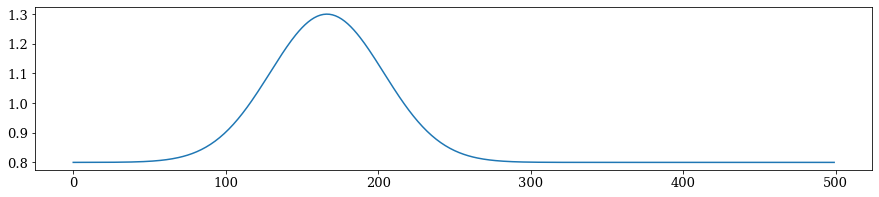

In [277]:
fig, ax = plt.subplots(figsize=(15, 3))
plt.plot(initial_condition)

In [278]:
def solve_upwind_scheme(initial_condition, t_vec, x_vec):
    """ solve a 1-d advection diffusion equation using the first order conservative upwind scheme"""
    U = np.zeros((len(x_vec), len(t_vec)))
    
    U[:, 0] = initial_condition
    
    dt = np.mean(t_vec[1:] - t_vec[:-1])
    dx = np.mean(x_vec[1:] - x_vec[:-1])
    
    for ii in range(len(t_vec) -1):
        for jj in range(len(x_vec)):
            if (U[jj, ii] * dt/dx) > 1:
                print("cfl violated. ")
                
            # force periodicity 
            if jj == len(x_vec) - 1:
                # F_{j+1/2}^{n}
                a1 = a_fun(U[jj, ii], U[0, ii])            
                F1 = (F_fun(U[0, ii]) + F_fun(U[jj, ii]))/2 - np.abs(a1)*(U[0, ii] - U[jj, ii])/2

            else:
                # F_{j+1/2}^{n}
                a1 = a_fun(U[jj, ii], U[jj + 1, ii])            
                F1 = (F_fun(U[jj + 1, ii]) + F_fun(U[jj, ii]))/2 - np.abs(a1)*(U[jj+1, ii] - U[jj, ii])/2

            # F_{j-1/2}^{n}
            a2 = a_fun(U[jj - 1, ii], U[jj, ii])
            F2 = (F_fun(U[jj, ii]) + F_fun(U[jj -1, ii]))/2 - np.abs(a2)*(U[jj, ii] - U[jj -1, ii])/2

            # update the next cell.
            U[jj, ii+1] = U[jj, ii] - (dt/dx)*(F1 - F2)
    return U

In [279]:
U_sol = solve_upwind_scheme(initial_condition, t_vec, x_vec)

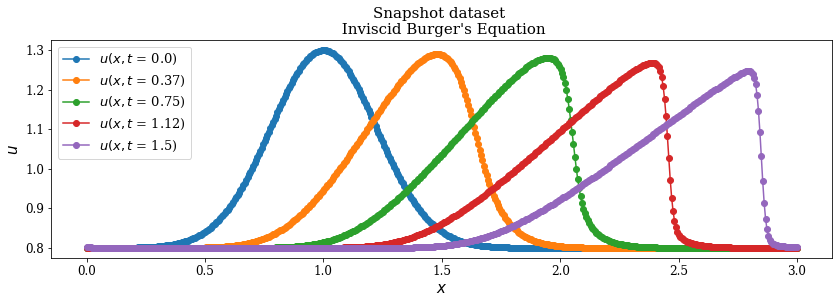

In [280]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.linspace(0, len(t_vec) -1, 5):
    ax.plot(x_vec, U_sol[:, int(ii)], "-o", label="$u(x, t$ = "+ str(round(t_vec[int(ii)], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Snapshot dataset \n Inviscid Burger's Equation", fontsize=15)
_ = ax.legend()

# Compute the spatial shift $s(t)$

In [281]:
def compute_spatial_shift(x_vec, t_vec, U, method=None):
    # initialize shift matrix. 
    shift_mat = np.zeros((len(x_vec), len(t_vec)))
    
    # phi at index 0 is original grid 
    shift_mat[:, 0] = np.zeros(len(x_vec))
    
    # delta t.
    dt = t_vec[1:] - t_vec[:-1]
    
    # compute the shift for each idx in t. 
    for ii in range(len(t_vec)-1):
        if method == "ballistic":
            shift = U[:, 0] * dt[ii]
        else:
            shift = U[:, ii]*dt[ii]
        shift_mat[:, ii+1] = shift_mat[:, ii] + shift
        
    return shift_mat

In [282]:
shift_mat = compute_spatial_shift(x_vec, t_vec, U_sol, method="ballistic")

# Shifted Coordinates

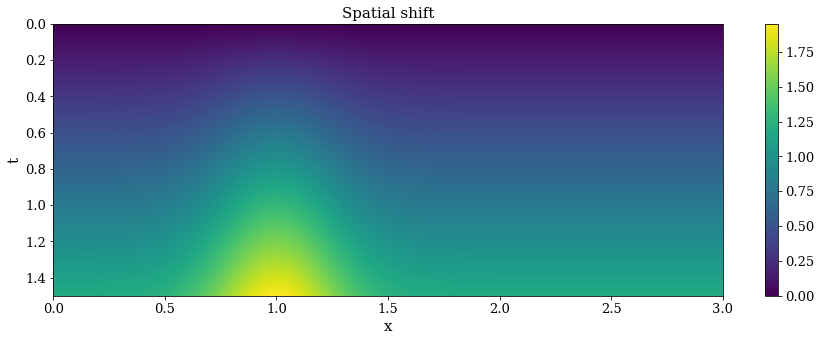

In [283]:
fig, ax = plt.subplots(figsize=(15, 5))
pos = ax.imshow(shift_mat.T, extent=[x_vec[0],x_vec[-1],t_vec[-1], t_vec[0]], aspect="auto")
cbar = fig.colorbar(pos, ax=ax)
#cbar.ax.set_ylabel('', rotation=90, fontsize=15)
_ = ax.set_xlabel(r"x", fontsize=15)
_ = ax.set_ylabel(r"t", fontsize=15)
_ = ax.set_title("Spatial shift", fontsize=15)

In [284]:
index_b = 100#350
index_e = 300#500
x_vec[index_e]

1.8036072144288577

In [285]:
print("x-begin", x_vec[index_b])
print("x-end", x_vec[index_e])

x-begin 0.6012024048096193
x-end 1.8036072144288577


In [286]:
c_r_vec = [0]

In [287]:
U_new = np.zeros(U_sol.shape)
U_new[:, 0] = U_sol[:, 0]
for ii in range(1, len(t_vec)):
    avg_shift = np.mean(shift_mat[index_b:index_e, ii]) #+ np.std(shift_mat[:, ii])
    c_r_vec.append(avg_shift)
    f_interp = interp1d(x_vec, U_sol[:, ii], fill_value="extrapolate")
    x_new = (x_vec + avg_shift) % (x_vec[-1])
    U_new[:, ii] = f_interp(x_new)

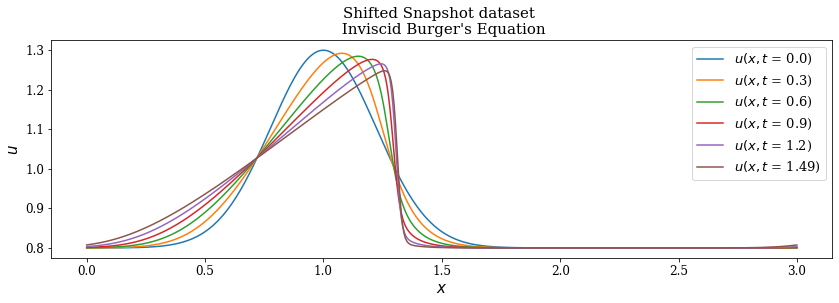

In [288]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, U_new[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Shifted Snapshot dataset \n Inviscid Burger's Equation", fontsize=15)
_ = ax.legend()

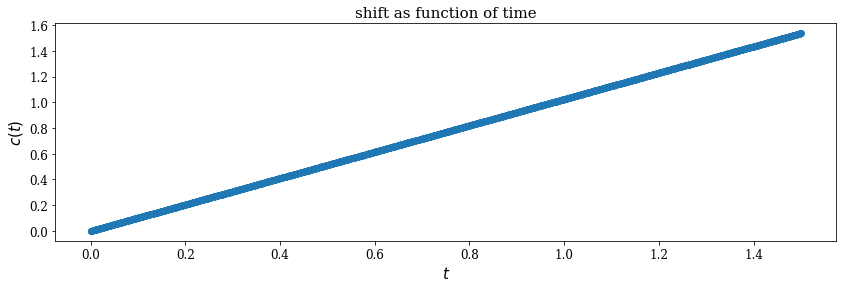

In [289]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(t_vec, c_r_vec, "-o")
_ = ax.set_xlabel("$t$", fontsize=15)
_ = ax.set_ylabel("$c(t)$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("shift as function of time", fontsize=15)

# Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [290]:
# set up the first l indexes used for training. 
l = int(0.8*(len(t_vec)))

In [291]:
X= U_new

In [292]:
X_train = X[:, :l]
X_test = X[:, l:-1]

In [293]:
t_train = t_vec[:l]
t_test = t_vec[l:-1]

In [294]:
print("U train shape", np.shape(X_train))
print("Time Interval train: " + str(t_vec[0]) + " to " + str(t_vec[l]))
print("\nU test shape", np.shape(X_test))
print("Time Interval test: " + str(t_vec[l]) + " to " + str(t_vec[-1]))

U train shape (500, 800)
Time Interval train: 0.0 to 1.2012012012012012

U test shape (500, 199)
Time Interval test: 1.2012012012012012 to 1.5


## Intrusive vs. non-intrustive ROM
* intrusive- ROM operators requires access to the discretized FOM operators.

* nonintrustive -learns ROMs from simulation data without direct access to the FOM operators. 

## Using the ROM Operator Inference Package
Since the FOM has the form
$$
    \frac{d}{dt}\mathbf{x}(t) = A \ln (\mathbf{x}(t)),\qquad\mathbf{x}(0) = \mathbf{x}_0,
$$
we seek a reduced model with that same structure,
$$
    \frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t),\qquad\hat{\mathbf{x}}(0) = \hat{\mathbf{x}}_0,
$$

but with $\hat{\mathbf{x}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$. Esentially, we apply the **Dynamic Mode Decomposition (DMD)** method to predict the solar wind proton velocity at several heliocentric distances. 

We have several tasks to consider:
1. Choosing the reduced-model dimension $r$,
2. Constructing a low-dimensional subspace,
3. Computing the right-hand side data matrix $\dot{X}$,
4. Constructing the ROM via Operator Inference,
5. Simulating the ROM, and
6. Evaluating the performance of the ROM.

We will do this quickly, then show each step in more detail.

#  Regularized OpInf Algorithm Pseudocode [1]
 
[1] Shane A. McQuarrie, Cheng Huang, Karen E. Willcox. "*Data-driven reduced-order models via regularized operator inference for a single-injector combustion process*"


### Step 1: Choosing the Reduced-model Dimension
There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [295]:
svdvals = la.svdvals(X_train)
svdvals_prev = la.svdvals(U_sol[:, :l])

In [296]:
# Calculate the cumulative energy.
thresh = .9999
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 6
r (Eularian coordinates)= 45


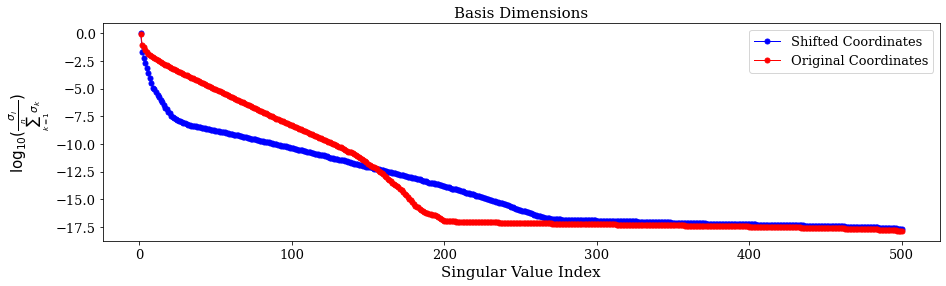

In [297]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, len(svdvals)+1), np.log10(svdvals/ np.sum(svdvals)), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, len(svdvals_prev) +1), np.log10(svdvals_prev/ np.sum(svdvals_prev)), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")


plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\log_{10}(\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}})$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

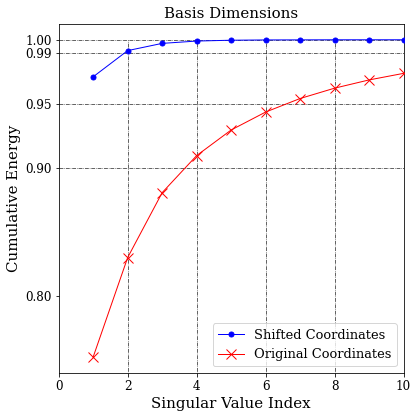

In [298]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(6, 6))

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ylim = ax.get_ylim()
# plot vertical and horizontal lines based on threshhold value
#ax.vlines(rank, 0, thresh, color="blue", linewidth=.6, linestyle="-.")
#ax.vlines(rank_prev, 0, thresh, color="red", linewidth=.6, linestyle="-.")


# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

ax.vlines(2, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(4, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(6, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(8, 0, 1, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()     
plt.savefig("figs/singular_value_decay_burgers.png", pad_inches=1)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [299]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (500, 6)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

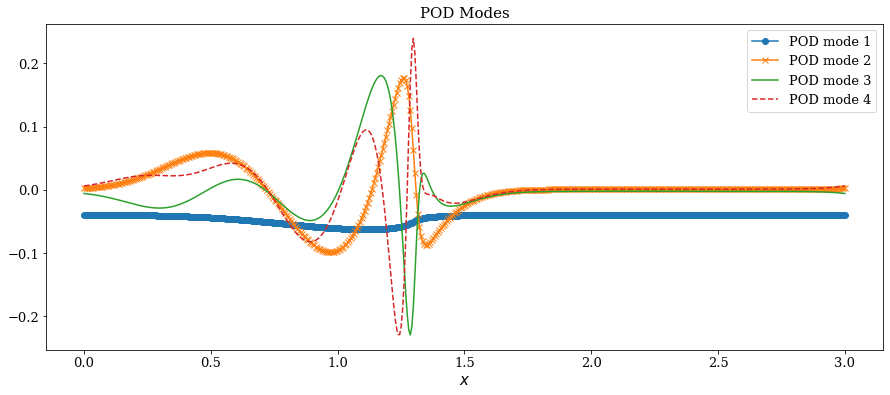

In [300]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(x_vec, Vr[:,0], "-o", label=f"POD mode {1}")
ax.plot(x_vec, Vr[:,1], "-x", label=f"POD mode {2}")
ax.plot(x_vec, Vr[:,2], "-", label=f"POD mode {3}")
ax.plot(x_vec, Vr[:,3], "--", label=f"POD mode {4}")
#ax.plot((180/np.pi) * p_new, Vr[:len(p_new),4], "-", label=f"POD mode {5}")

ax.set_xlabel("$x$", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
plt.legend(loc="upper right")
plt.show()

In [301]:
roi.pre.projection_error(X_train, Vr)

9.485508224294675e-05

### Calculating the right-hand side Data Matrix

Operator Inference constructs the ROM by solving a least-squares problem that corresponds to the form of the model.
In this case, the original model has the form $\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t)$.
The snapshot matrix $X$ contains data for $\mathbf{x}(t)$, but we also need data for $\frac{d}{dt}\mathbf{x}(t)$.
In this simple example, we can directly compute the _snapshot time derivative matrix_ $\dot{X}\in\mathbb{R}^{n\times k}$ that corresponds to the snapshots by setting $\dot{X} = A X$.

\If the matrix $A$ is unknown or computationally unavailable, the time derivative matrix can be estimated through finite differences of the snapshots.
The `pre` submodule has some convenience tools for this.
Since our time domain is uniformly spaced, we use `roi.pre.xdot_uniform()`; for snapshots that are not uniformly spaced in time, see `roi.pre.xdot_nonuniform()`.

We also note that the finite difference approximation for $\dot{X}$ commutes with the projection to a low-dimensional subspace; in other words, $V_{r}^\mathsf{T}\frac{d}{dt}\left[X\right] = \frac{d}{dt}\left[V_{r}^\mathsf{T}X\right]$.
To save memory, the snapshot matrix may be projected first, and the projected time derivatives can be calculated from the projected snapshots.
The ROM classes in the next section accept both full-order ($n \times k$) or reduced-order ($r\times k$) snapshot and time derivative matrices as training data.

In [302]:
X_ = Vr.T @ X_train                                  # Project the state snapshots.
Xdot_ = roi.pre.xdot_uniform(X_, (t_vec[1]-t_vec[0]), order = 6) # Estimate the projected time derivatives.

In [303]:
model = roi.InferredContinuousROM("A")
print(model)

Reduced-order model structure: dx / dt = Ax(t)


We now fit the model to the data by solving the least squares problem
$$
    \min_{\hat{A}\in\mathbb{R}^{r\times r}}\left\|\hat{A}\hat{X} - \dot{\hat{X}}\right\|_{F}^2,
$$
where
$$
\begin{align*}
    \hat{X} &= V_r^\mathsf{T}X,
    &
    \dot{\hat{X}} &= V_r^\mathsf{T}\dot{X}.
\end{align*}
$$
This is all done in the `fit()` method, given $X$, $\dot{X}$, and $V_r$.

In [304]:
model.fit(Vr, X_train, Xdot_, P=1e3)

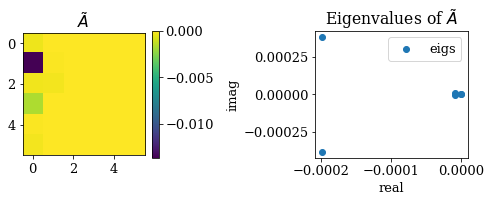

In [305]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
pos = ax[0].imshow(model.A_)
cbar = fig.colorbar(pos, ax=ax[0])
_ = ax[0].set_title(r"$\tilde A$")

# eigendecomposition of A. 
eigA, eigvecA = np.linalg.eig(model.A_)

_ = ax[1].scatter(eigA.real, eigA.imag, label="eigs")
_ = ax[1].set_xlabel("real")
_ = ax[1].set_ylabel("imag")
_ = ax[1].set_title("Eigenvalues of " + r"$\tilde A$")
_ = plt.legend()
_ = plt.tight_layout()

### Simulating the Reduced Model
Once the model is fit, we may simulate the ROM with the `predict()` method, which wraps `scipy.integrate.solve_ivp()`.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [306]:
X_ROM = model.predict(X[:, 0], t_vec, method="BDF")
X_ROM.shape

(500, 1000)

### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output `X_ROM`.
It should look similar to the plot of the snapshot data `X`.

In [307]:
shift_rom = compute_spatial_shift(x_vec, t_vec, X_ROM, method="ballistic")

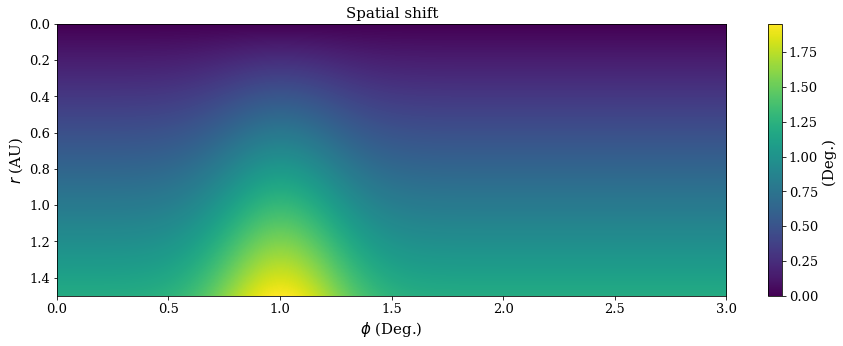

In [308]:
fig, ax = plt.subplots(figsize=(15, 5))
pos = ax.imshow(shift_rom.T, extent=[x_vec[0],x_vec[-1],t_vec[-1], t_vec[0]], aspect="auto")
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('(Deg.) ', rotation=90, fontsize=15)
_ = ax.set_xlabel(r"$\phi$ (Deg.)", fontsize=15)
_ = ax.set_ylabel(r"$r$ (AU)", fontsize=15)
_ = ax.set_title("Spatial shift", fontsize=15)

In [309]:
def convert_from_x_to_v(X_ROM):
    V_ROM = np.zeros(X_ROM.shape)
    V_ROM[:, 0] = X_ROM[:, 0]
    phi_shift_rom = compute_spatial_shift(x_vec, t_vec, X_ROM)
    for jj in range(1, len(t_vec)):
        avg_shift = np.mean(phi_shift_rom[index_b:index_e, jj]) #+ np.std(shift_mat[jj, :])
        f_interp = interp1d(x_vec, X_ROM[:, jj], fill_value="extrapolate")
        x_new = (x_vec - avg_shift) % (x_vec[-1])
        V_ROM[:, jj] = f_interp(x_new)
    return V_ROM

In [310]:
V_ROM = convert_from_x_to_v(X_ROM)

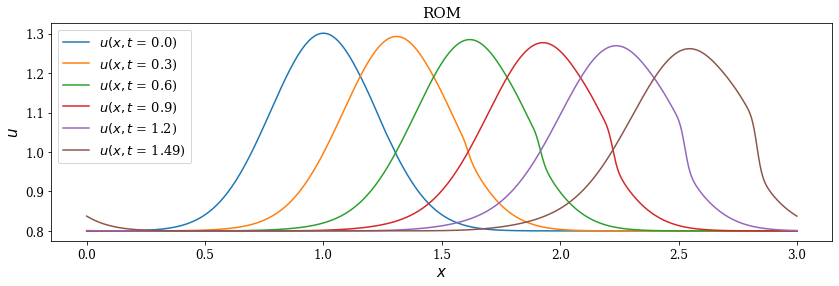

In [311]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, V_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("ROM", fontsize=15)
_ = ax.legend()

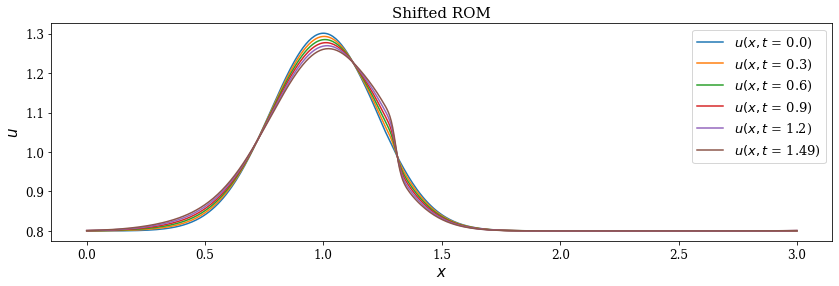

In [312]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, X_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Shifted ROM", fontsize=15)
_ = ax.legend()


For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

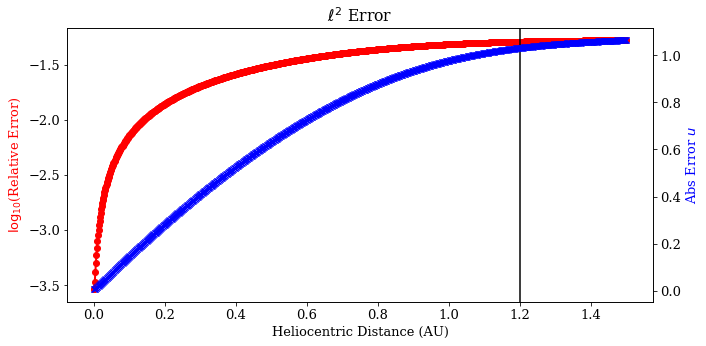

In [313]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(U_sol, V_ROM, p=2)
_ = ax.plot(t_vec, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(t_vec[l], c="k")
_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(t_vec, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $u$", c="b")

plt.tight_layout()

In [314]:
abs_froerr, rel_froerr = roi.post.frobenius_error(U_sol, V_ROM)
print(f"Relative error: {rel_froerr:%}")

Relative error: 3.946827%


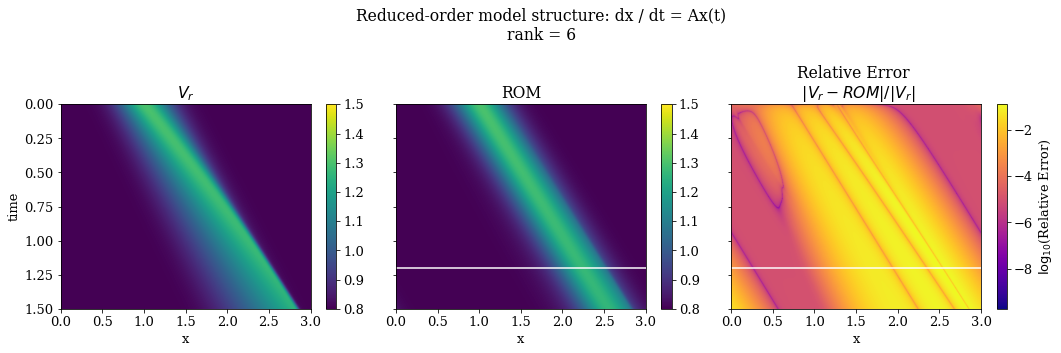

In [315]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(U_sol.T, extent=[a, b, T, 0], vmax=0.8, vmin=1.5, aspect="auto")
ax[0].set_xlabel(r"x")
ax[0].set_ylabel(r"time")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])

pos = ax[1].imshow(V_ROM.T, extent=[a,b, T, 0], vmax=0.8, vmin=1.5, aspect="auto")
ax[1].set_xlabel("x")
ax[1].set_title("ROM")
ax[1].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])

pos = ax[2].imshow(np.log10(np.abs(V_ROM.T - U_sol.T)/np.abs(U_sol).T), extent=[a,b, T, 0], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"x")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('$\log_{10}$(Relative Error)', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

In [316]:
print("mean relative error = ", np.mean(np.abs((U_sol.T - V_ROM.T))/np.abs(U_sol.T)))

mean relative error =  0.01868132690577337


# Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$

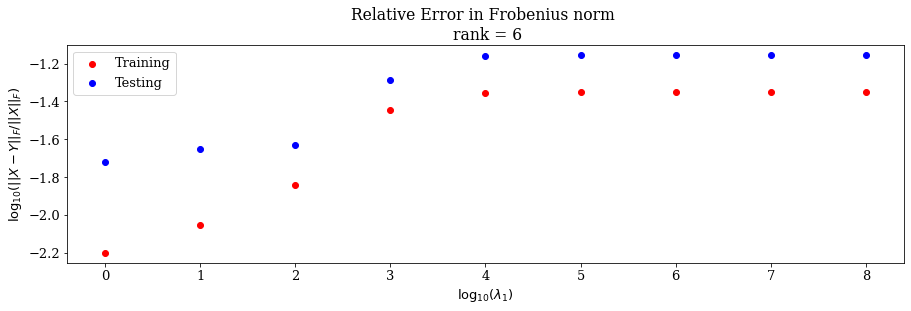

In [317]:
fig, ax = plt.subplots(figsize=(15, 4))

for coeff in [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]:# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (t_vec[1]-t_vec[0]), order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(U_sol[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(U_sol[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm \n rank = " + str(rank))
_ = plt.legend()

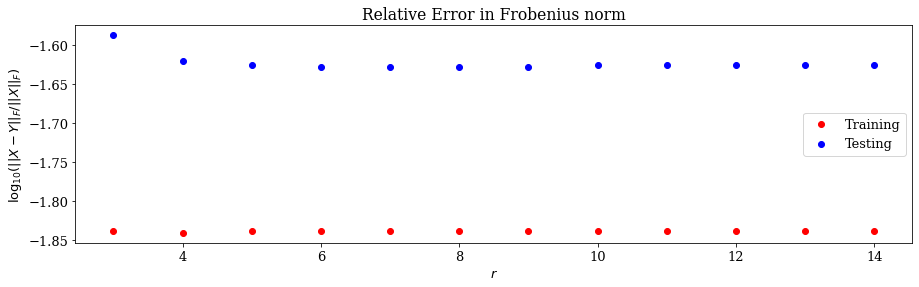

In [318]:
fig, ax = plt.subplots(figsize=(15, 4))

for r_val in np.arange(3, 15):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (t_vec[1] - t_vec[0]), order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1e2)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(U_sol[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(U_sol[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$r$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

# Quadratic ROM

In [349]:
# Calculate the cumulative energy.
thresh = .9999

cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

r = 6


In [350]:
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train, t_vec[1]-t_vec[0], order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=1e1)                          # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.

In [351]:
V_ROM = convert_from_x_to_v(X_ROM)

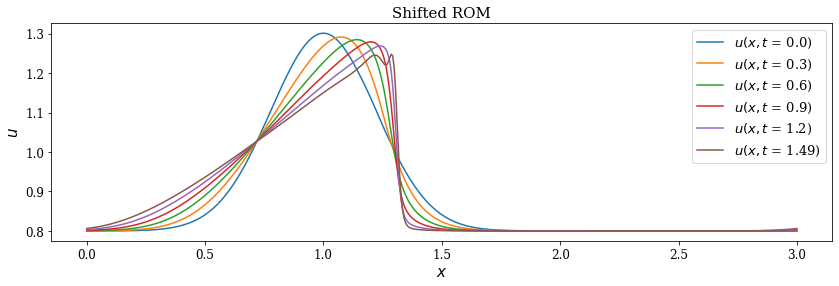

In [352]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, X_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("Shifted ROM", fontsize=15)
_ = ax.legend()

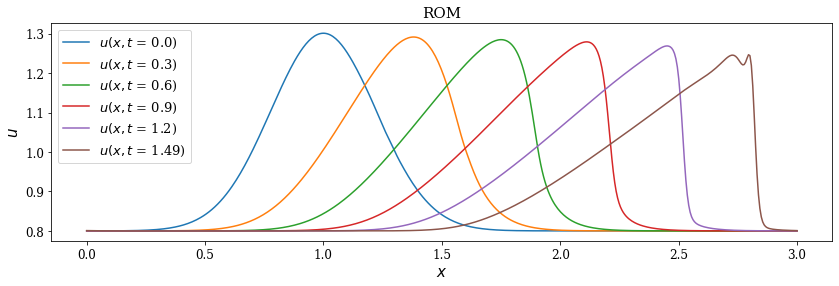

In [353]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.arange(0, len(t_vec), 199):
    ax.plot(x_vec, V_ROM[:, ii], label="$u(x, t$ = "+ str(round(t_vec[ii], 2)) + ")")
_ = ax.set_xlabel("$x$", fontsize=15)
_ = ax.set_ylabel("$u$", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
_ = ax.set_title("ROM", fontsize=15)
_ = ax.legend()

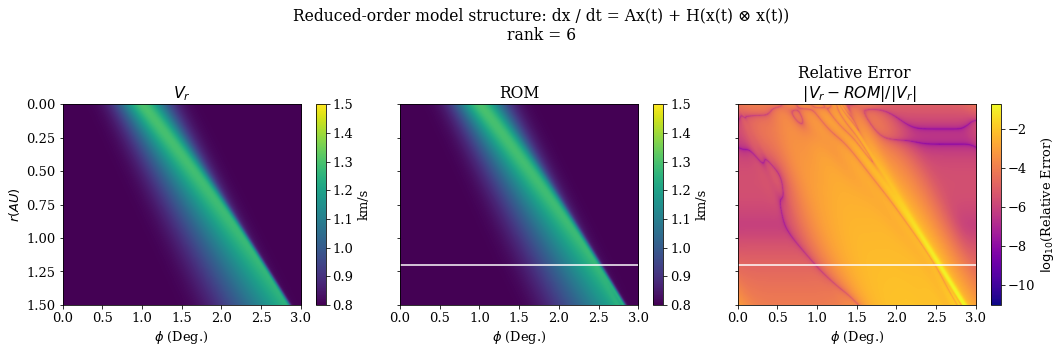

In [354]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(U_sol.T, extent=[a, b,T, 0], vmax=0.8, vmin=1.5, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r (AU)$")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[a,b,T, 0], vmax=0.8, vmin=1.5, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("ROM")
ax[1].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.log10(np.abs(V_ROM.T - U_sol.T)/np.abs(U_sol).T), extent=[a,b,T, 0], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(x_vec, t_train[-1]* np.ones(len(x_vec)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('$\log_{10}$(Relative Error)', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

In [355]:
print("mean relative error = ", np.mean(np.abs((U_sol.T - V_ROM.T))/np.abs(U_sol.T)))

mean relative error =  0.002082807992207946


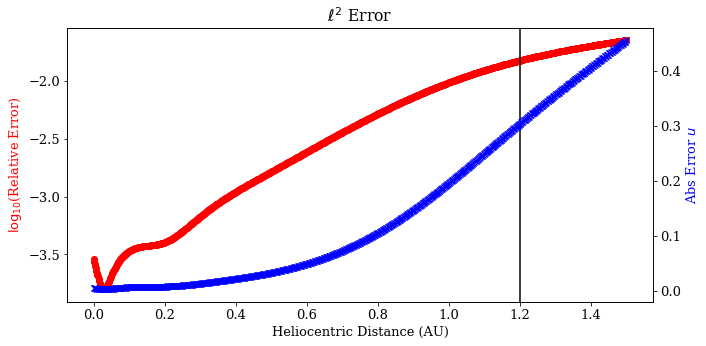

In [356]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(U_sol, V_ROM, p=2)
_ = ax.plot(t_vec, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(t_vec[l], c="k")
_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(t_vec, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $u$", c="b")

plt.tight_layout()

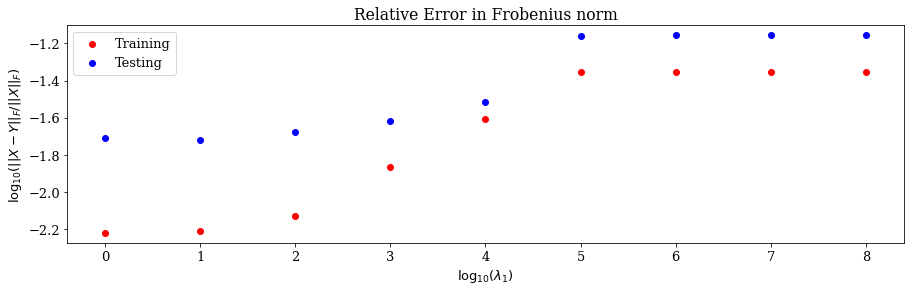

In [357]:
fig, ax = plt.subplots(figsize=(15, 4))

for coeff in [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]:# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, t_vec[1] - t_vec[0], order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(U_sol[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(U_sol[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

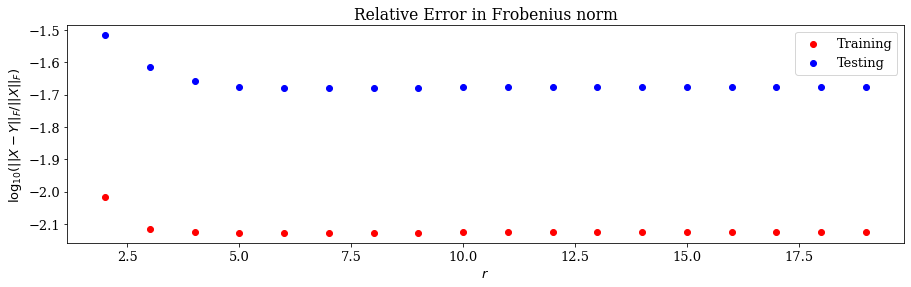

In [358]:
fig, ax = plt.subplots(figsize=(15, 4))

for r_val in np.arange(2, 20):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (t_vec[1] - t_vec[0]), order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="AH")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1e2)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(U_sol[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(U_sol[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$r$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

# Sensitivity to Training Data

* **Test 1**: 120 training snapshots. 

* **Test 2**: 150 training snapshots. 

* **Test 3**: 180 training snapshots.

In [57]:
# initialize the training length. 
l1, l2, l3 = 300, 400, 500


X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [58]:
r_train1 = t_vec[:l1]
r_test1 = t_vec[l1:-1]

r_train2 = t_vec[:l2]
r_test2 = t_vec[l2:-1]

r_train3 = t_vec[:l3]
r_test3 = t_vec[l3:-1]

In [59]:
# l1 = compute the results for quadradic with 3 modes.
rank=4
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, t_vec[1] - t_vec[0], order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1E4)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM1 = convert_from_x_to_v(X_ROM1)

# l2 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, t_vec[1] - t_vec[0], order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1E4)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM2 = convert_from_x_to_v(X_ROM2)

# l3 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, t_vec[1] - t_vec[0], order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1E4)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], t_vec, method="BDF") # Simulate the ROM.
V_ROM3 = convert_from_x_to_v(X_ROM3)

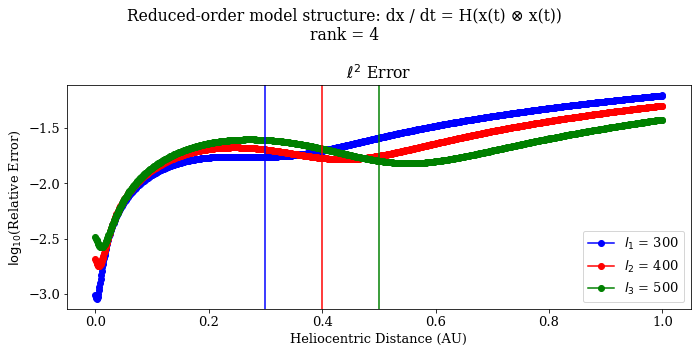

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(U_sol, V_ROM1)
_ = ax.plot(t_vec, np.log10(rel_l2err1), "-o", c="b", label="$l_{1}$ = " + str(l1))

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(U_sol, V_ROM2)
_ = ax.plot(t_vec, np.log10(rel_l2err2), "-o", c="r", label="$l_{2}$ = " + str(l2))

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(U_sol, V_ROM3)
_ = ax.plot(t_vec, np.log10(rel_l2err3), "-o", c="g", label="$l_{3}$ = " + str(l3))

_ = ax.axvline(r_train1[-1], c="b")
_ = ax.axvline(r_train2[-1], c="r")
_ = ax.axvline(r_train3[-1], c="g")
_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.legend()
plt.suptitle(str(model) + "\n" + "rank = " + str(rank))
plt.tight_layout()